# Machine Learning from Start to Finish with Scikit-Learn
This notebook covers the basic Machine Learning process in Python step-by-step. Go from raw data to at least78% accuracy on the Titanic Survivors dataset.

## Steps Covered
1. Import a DataFrame
2. Visualize the Data
3. Cleanup and Transform the Data
4. Encode the Data
5. Split Training and Test Sets
6. Fine Tune Algorithms
7. Cross Validate with KFold
8. Upload to Kaggle

# CSV to DataFrame
CSV files can be loaded into a dataframe by calling pd.read_csv. After loading the training and test files, print a sample to see what you're woking with.
You could download [*data for train and test*](https://www.kaggle.com/c/titanic)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
453,454,1,1,"Goldenberg, Mr. Samuel L",male,49.0,1,0,17453,89.1042,C92,C
716,717,1,1,"Endres, Miss. Caroline Louise",female,38.0,0,0,PC 17757,227.5250,C45,C
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3000,B35,C


# Visualizing Data
Visualizing data is crucial for recognizing underlying patterns to exploit in the model.(**You should explore more pairs to find pattern**)

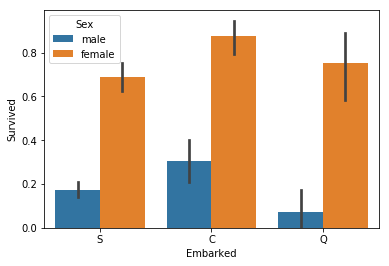

In [4]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train)

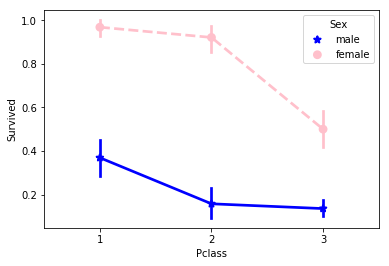

In [5]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train, palette={"male": "blue", "female": "pink"},
             markers=["*", "o"], linestyles=["-", "--"])

# Transforming Features
1. Ａside from 'Sex', the 'Age' feature is second in importtance(**How do you know that?**). *To avoid overfitting*, I'm grouping people into logical human age groups.
2. *Each Cabin* starts with a letter(**You should find some pattern in the data**). I *bet* this letter is much more important than the number that follows, lets's slice it off.
3. Fare is *another continuous* value that should be simplifield. I ran data_train. Fare.describe() to get the distribution of the feature, then placed them into quartile bins accordingly.
4. Extract information from the 'Name' feature. Rather than use the full name, I extracted the last name and name prefix (Mr. Mrs. Etc.), then appended them as their own features.
5. Lastly, drop useless features.(Ticket and Name)(**Knowledge of life**)

In [6]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unkown', "Baby", "Child", "Teenager", "Student", "Young Adult", "Adult", "Senior"]
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ["Unknown", "1_quartile", "2_quartile", "3_quartile", "4_quartile"]
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df["Lname"] = df.Name.apply(lambda x: x.split(" ")[0])
    df["NamePrefix"] = df.Name.apply(lambda x: x.split(" ")[1])
    return df

def drop_features(df):
    return df.drop(["Ticket", "Name", "Embarked"], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


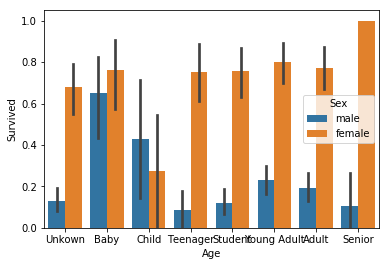

In [7]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train)

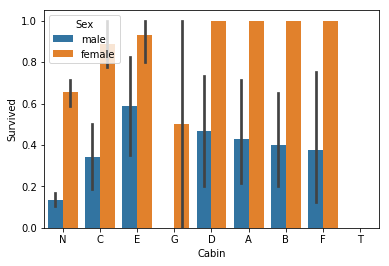

In [8]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train)

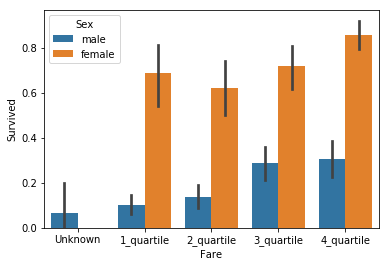

In [9]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train)

# Some Final Encoding
The last part of the preprocessing phase is to normalize labels.The LabelEncoder in Scikit-learn will convert each unique string value iinto a number, making out data more flexible for various algorithms.  

The result is a table of numbers that looks scary to humans, but beautiful to machines.

In [10]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ["Fare", "Cabin", "Age", "Sex", "Lname", "NamePrefix"]
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


# Splitting up the Training Data
Now its time for some Machine Learning.  

First, separate the feature(X) from the labels(y).   

**X_all**: All features minus the value we want to predict(Survived).  

**y_all**: Only the value we want to predict.  

Second, use Scikit-learn to randomly shuffle this data into four variables. In this case, I'm training 80% of the data, then testing against the other 20%.  

Later, this data will be reorganized into a KFold pattern to validate the effectiveness of a trained algorithm.  

In [11]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(["Survived", "PassengerId"], axis=1)
y_all = data_train["Survived"]

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier
clf = RandomForestClassifier()

# Choose some parameter combinations to try
paramters = {
    "n_estimators": [4, 6, 9],
    "max_features": ["log2", "sqrt", "auto"],
    "criterion": ["entropy", "gini"],
    "max_depth": [2, 3, 5, 10],
    "min_samples_split": [2, 3, 5],
    "min_samples_leaf": [1, 5, 8]
}

# Type of sscoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, paramters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data.
clf.fit(X_train, y_train)

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test,predictions))

0.8100558659217877


In [90]:
from sklearn.model_selection import KFold

def run_kfold(clf):
    kf = KFold(n_splits=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(X_all):
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print(f"Fold {fold} accuracy: {accuracy}")     
    mean_outcome = np.mean(outcomes)
    print(f"Mean Accuracy: {mean_outcome}")
    
run_kfold(clf)

Fold 1 accuracy: 0.8222222222222222
Fold 2 accuracy: 0.8539325842696629
Fold 3 accuracy: 0.7865168539325843
Fold 4 accuracy: 0.8651685393258427
Fold 5 accuracy: 0.8202247191011236
Fold 6 accuracy: 0.797752808988764
Fold 7 accuracy: 0.7752808988764045
Fold 8 accuracy: 0.797752808988764
Fold 9 accuracy: 0.8651685393258427
Fold 10 accuracy: 0.8089887640449438
Mean Accuracy: 0.8193008739076154


In [26]:
ids = data_test["PassengerId"]
predictions = clf.predict(data_test.drop("PassengerId", axis=1))

output = pd.DataFrame({"PassengerId": ids,
                       "Survived": predictions})
output.to_csv("titanic-predictions.csv", index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [30]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int32
Age            891 non-null int32
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null int32
Cabin          891 non-null int32
Lname          891 non-null int32
NamePrefix     891 non-null int32
dtypes: int32(6), int64(5)
memory usage: 55.8 KB


In [31]:
data_train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,4.031425,0.523008,0.381594,1.531987,5.946128,428.940516,18.159371
std,257.353842,0.486592,0.836071,0.477990,2.634925,1.102743,0.806057,1.164956,2.062347,252.853561,2.987872
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,7.000000,216.500000,16.000000
50%,446.000000,0.000000,3.000000,1.000000,4.000000,0.000000,0.000000,2.000000,7.000000,414.000000,19.000000
75%,668.500000,1.000000,3.000000,1.000000,6.000000,1.000000,0.000000,3.000000,7.000000,649.500000,19.000000
max,891.000000,1.000000,3.000000,1.000000,7.000000,8.000000,6.000000,4.000000,8.000000,867.000000,33.000000


In [32]:
import numpy as np

In [35]:
conv = np.cov(data_train['Age'], data_train['Survived'])

In [36]:
pho = conv[1]

In [38]:
pho = (conv[0][1])/(np.sqrt(conv[0][0]*conv[1][1]))

In [39]:
pho

-0.048854155271592384

In [45]:
ages = data_train['Age']

In [49]:
data_train.cov()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
PassengerId,66231.000000,-0.626966,-7.561798,5.282022,-8.341573,-16.325843,-0.342697,-1.680899,-17.557303,-2577.531461,4.083146
Survived,-0.626966,0.236772,-0.137703,-0.126376,-0.062638,-0.018954,0.032017,0.142765,-0.296153,-7.125457,-0.180343
Pclass,-7.561798,-0.137703,0.699015,0.052712,0.489166,0.076599,0.012429,-0.637412,1.279567,10.908267,0.029408
Sex,5.282022,-0.126376,0.052712,0.228475,0.042548,-0.060422,-0.094584,-0.107816,0.116949,2.563283,0.167464
Age,-8.341573,-0.062638,0.489166,0.042548,6.942832,-0.232185,-0.507511,-0.738085,1.099448,37.970411,1.414087
SibSp,-16.325843,-0.018954,0.076599,-0.060422,-0.232185,1.216043,0.368739,0.451791,0.093376,-4.389079,-0.568839
Parch,-0.342697,0.032017,0.012429,-0.094584,-0.507511,0.368739,0.649728,0.333848,-0.052453,-9.637950,-0.363131
Fare,-1.680899,0.142765,-0.637412,-0.107816,-0.738085,0.451791,0.333848,1.357122,-1.222994,-17.768320,-0.303980
Cabin,-17.557303,-0.296153,1.279567,0.116949,1.099448,0.093376,-0.052453,-1.222994,4.253274,26.999039,0.185000
Lname,-2577.531461,-7.125457,10.908267,2.563283,37.970411,-4.389079,-9.637950,-17.768320,26.999039,63934.923424,-13.805116


In [95]:
data_train.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
PassengerId,1.000000,-0.005007,-0.035144,0.042939,-0.012301,-0.057527,-0.001652,-0.005607,-0.033080,-0.039610,0.005310
Survived,-0.005007,1.000000,-0.338481,-0.543351,-0.048854,-0.035322,0.081629,0.251852,-0.295113,-0.057913,-0.124043
Pclass,-0.035144,-0.338481,1.000000,0.131900,0.222047,0.083081,0.018443,-0.654436,0.742093,0.051599,0.011772
Sex,0.042939,-0.543351,0.131900,1.000000,0.033782,-0.114631,-0.245489,-0.193622,0.118635,0.021208,0.117257
Age,-0.012301,-0.048854,0.222047,0.033782,1.000000,-0.079908,-0.238952,-0.240452,0.202323,0.056991,0.179616
SibSp,-0.057527,-0.035322,0.083081,-0.114631,-0.079908,1.000000,0.414838,0.351685,0.041058,-0.015741,-0.172645
Parch,-0.001652,0.081629,0.018443,-0.245489,-0.238952,0.414838,1.000000,0.355528,-0.031553,-0.047288,-0.150777
Fare,-0.005607,0.251852,-0.654436,-0.193622,-0.240452,0.351685,0.355528,1.000000,-0.509042,-0.060321,-0.087332
Cabin,-0.033080,-0.295113,0.742093,0.118635,0.202323,0.041058,-0.031553,-0.509042,1.000000,0.051775,0.030023
Lname,-0.039610,-0.057913,0.051599,0.021208,0.056991,-0.015741,-0.047288,-0.060321,0.051775,1.000000,-0.018273


In [97]:
corr = data_train.corr()

In [98]:
corr.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,0.078029,-0.010418,0.112079,0.033512,0.097663,0.128626,0.104975,0.018932,0.119738,0.085675,0.071901
std,0.306972,0.398521,0.450928,0.379793,0.338498,0.343002,0.364363,0.458648,0.424450,0.306542,0.326512
min,-0.057527,-0.543351,-0.654436,-0.543351,-0.240452,-0.172645,-0.245489,-0.654436,-0.509042,-0.060321,-0.172645
25%,-0.034112,-0.209578,-0.011686,-0.154126,-0.064381,-0.068717,-0.099032,-0.217037,-0.032317,-0.043449,-0.105687
50%,-0.005607,-0.048854,0.051599,0.033782,0.033782,-0.015741,-0.001652,-0.060321,0.041058,-0.015741,0.005310
75%,0.001829,0.038311,0.176974,0.117946,0.190970,0.217383,0.218578,0.301769,0.160479,0.051687,0.073640
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [99]:
corr.median()

PassengerId   -0.005607
Survived      -0.048854
Pclass         0.051599
Sex            0.033782
Age            0.033782
SibSp         -0.015741
Parch         -0.001652
Fare          -0.060321
Cabin          0.041058
Lname         -0.015741
NamePrefix     0.005310
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002886C92C400>]],
      dtype=object)

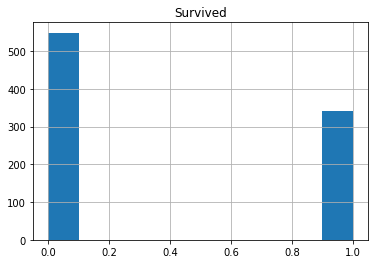

In [104]:
data_train.hist('Survived')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002886DEFD320>]],
      dtype=object)

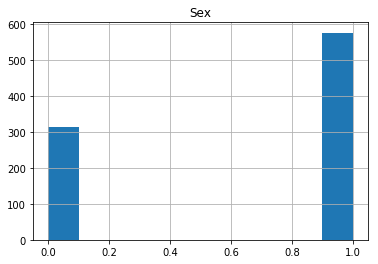

In [107]:
data_train.hist('Sex')

In [101]:
import torch

In [105]:
import cv2 as cv

In [116]:
t = torch.add([1, 2], [2,8])

TypeError: add(): argument 'input' (position 1) must be Tensor, not list

In [117]:
t.topk([1])

TypeError: topk(): argument 'k' (position 1) must be int, not list

In [118]:
t.topk?

Docstring:
topk(k, dim=None, largest=True, sorted=True) -> (Tensor, LongTensor)

See :func:`torch.topk`
Type:      builtin_function_or_method


In [120]:
data_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19
5,6,0,3,1,6,0,0,1,7,538,19
6,7,0,1,1,0,0,0,3,4,500,19
7,8,0,3,1,1,3,1,2,7,608,13
8,9,1,3,0,7,0,2,1,7,382,20
9,10,1,2,0,5,1,0,2,7,559,20
